### Exercise 2b)

In [1]:
from utils.neural_network import NeuralNetwork
import numpy as np
import matplotlib.pyplot as plt
from utils.training import StochasticGradientDescent
from utils.step_methods import RMSpropStep
from utils.cost_functions import MSE
from utils.activation_functions import Sigmoid, Identity, LeakyReLU
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from utils.utils import generate_dataset, runge
from copy import deepcopy

plt.style.use('./utils/_plot_style.mplstyle')


In [ ]:
# Dataset
np.random.seed(124)

n = 500
x, y = generate_dataset(n)

In [15]:
# OLS model
ols_model = make_pipeline(
    PolynomialFeatures(degree=12, include_bias=False),
    StandardScaler(),
    LinearRegression(fit_intercept=False)
)

In [16]:
# Neural network model
network_input_size = x.shape[1]
network_output_size = 1

layer_output_sizes = [4, 2, network_output_size]
activation_funcs = [LeakyReLU(), Sigmoid(), Identity()]

nn_model = NeuralNetwork(
    network_input_size,
    layer_output_sizes,
    activation_funcs,
    MSE(),
)
initial_layers = nn_model.layers # Store initial parameters to reset for each fold
nn_scaler = StandardScaler() # Scaler for neural network input data

In [17]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=44)

nn_mse = np.zeros(n_splits)
ols_mse = np.zeros(n_splits)


for fold_idx,(train_idx, test_idx) in enumerate(kfold.split(x)): 
    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Scale data
    x_train_scaled = nn_scaler.fit_transform(x_train)
    x_test_scaled = nn_scaler.transform(x_test)

    # Train and evaluate Neural Network
    nn_model.layers = deepcopy(initial_layers) # Reset neural network layers
    nn_model.train(
        StochasticGradientDescent(
            step_method = RMSpropStep(learning_rate=0.01, decay_rate=0.9),
            inputs = x_train_scaled,
            targets = y_train - y_mean,
        ),
        num_iterations = 3000
    )
    y_pred_nn = nn_model.predict(x_test_scaled) + y_mean
    nn_mse[fold_idx] = MSE()(y_pred_nn, y_test)

    # Train and evaluate OLS model
    ols_model.fit(x_train, y_train - y_mean) # This model already includes a scaler
    y_pred_ols = ols_model.predict(x_test) + y_mean
    ols_mse[fold_idx] = MSE()(y_pred_ols, y_test)


In [18]:
print(f"{n_splits}-fold {'NN MSE:':10} {nn_mse.mean():.3e}")
print(f"{n_splits}-fold {'OLS MSE:':10} {ols_mse.mean():.3e}")

5-fold NN MSE:    2.766e-03
5-fold OLS MSE:   3.377e-03


## Visualize the function approximation with NN and OLS

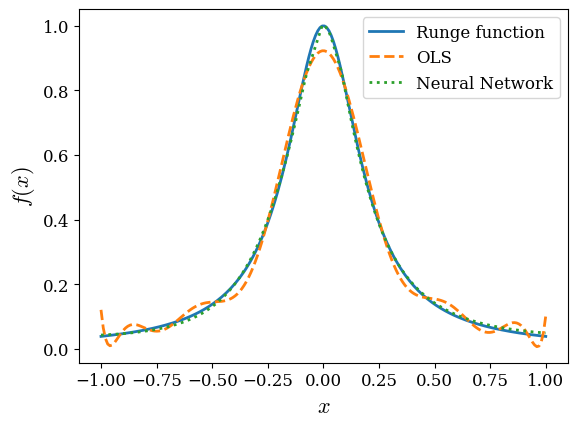

In [19]:
x_test = np.linspace(-1,1, 200).reshape(-1, 1)

y_pred_nn = nn_model.predict(nn_scaler.transform(x_test)) + y_mean
y_pred_ols = ols_model.predict(x_test) + y_mean


plt.plot(x_test, runge(x_test), label="Runge function")
plt.plot(x_test, y_pred_ols, linestyle="dashed", label="OLS")
plt.plot(x_test, y_pred_nn, linestyle="dotted", label="Neural Network")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()
plt.savefig("../figs/runge_approximation_nn_vs_ols.pdf")
plt.show()